<h1>Step 0: import module for distillbert_QA project</h1>

In [2]:
#step 0
import json
import os
from dataset import read_jsonl
import re
# step 1
from sklearn.model_selection import train_test_split
# step 4
from transformers import DistilBertTokenizerFast, DistilBertForQuestionAnswering
from transformers import AdamW
# step 6
import torch as th
# step 7
from torch.utils.data import DataLoader
# step 10
import time

os.chdir('/home/sangmin/grade-school-math/grade_school_math/')

<h1>Step 1: Retrieve and Store the data</h1>
Here I take and store the texts, queries and answers from the train and validation .json files. I save these informations into lists.

In [3]:
path = os.path.join("data/train.jsonl")
objs = read_jsonl(path)

texts = []
queries = []
answers = []

for i in objs:

    answer_info = {}

    an = i['answer']
    co = re.findall('.+\n#', an)
    ans = re.findall('\d+$', an)

    context = co[0]
    answer_info['text'] = ans[0]
    answer_info['answer_start'] = context.rfind('>>') + 2
    question = i['question']
        
    texts.append(context)
    answers.append(answer_info)
    queries.append(question)

train_texts, val_texts, train_queries, val_queries, train_answers, val_answers = train_test_split(texts, queries, answers, test_size=0.15, shuffle=True)


<H1>Step 2: Check the data</H1>

As you can see we have 7473 passages, queries and answers from the training data. The answer is stored in a dictionary with the specific answer in the "text" cell and the accurate character index that the answer is started in cell "answer start". As we observe, we need to fill the information about the exact index of the character that the answer is ending from the referance.

In [4]:
print(len(train_texts))
print(len(train_queries))
print(len(train_answers))

6352
6352
6352


In [5]:
print("Passage: ",train_texts[0:2])  
print("Query: ",train_queries[0:2])
print("Answer: ",train_answers[0:2])

Passage:  ['260 gallons divided by 20 gallons per second 260/20 = <<260/20=13>>13 seconds\n#', 'Then add both increases to the base price to find the new price: $50 + $5 + $15 = $<<50+5+15=70>>70\n#']
Query:  ['24 gallons per second of water flows down a waterfall. If you have an empty basin that can hold 260 gallons of water. The basin leaks water at 4 gallons per second. how long would it take to fill the basin with water from the waterfall in seconds?', "Olivia's insurance premium starts out at $50/month. It goes up 10% for every accident and $5/month for every ticket. If she gets in one accident and gets 3 tickets, what's her new insurance premium?"]
Answer:  [{'text': '13', 'answer_start': 67}, {'text': '70', 'answer_start': 97}]


In [6]:
print(len(val_texts))
print(len(val_queries))
print(len(val_answers))

1121
1121
1121


In [7]:
print("Passage: ",val_texts[1])  
print("Query: ",val_queries[1])
print("Answer: ",val_answers[1])

Passage:  So, the rancher will need to spend 36*10 = $<<36*10=360>>360 per year on feed corn.
#
Query:  A rancher owns a mixture of 8 sheep and 5 cattle that graze on his land.  In a typical year, the rancher will allow his animals to feed off his pastures for as long as possible before they run out of grass.  After the pastures run out of grass, he must buy feed corn for $10 per bag.  Each cow eats 2 acres of grass per month, and each sheep eats 1 acre of grass per month.  Additionally, a bag of feed corn can feed each cow for 1 month and each sheep for 2 months.   If the rancher's pasture contains 144 acres of grass, how much will the rancher need to spend on feed corn to feed his animals each year?
Answer:  {'text': '360', 'answer_start': 57}


<h1>Step 3: Find the end position character</h1>
Because distilBert model needs both start and end position characters of the answer, I have to find it and store it for later. 

In [8]:
#Find end position character in train data.
for answer, text in zip(train_answers, train_texts):
    real_answer = answer['text']
    start_idx = answer['answer_start']
    end_idx = start_idx + len(real_answer) -1
    answer['answer_end'] = end_idx

In [9]:
#Find end position character in valid data.
for answer, text in zip(val_answers, val_texts):
    real_answer = answer['text']
    start_idx = answer['answer_start']
    end_idx = start_idx + len(real_answer) -1
    answer['answer_end'] = end_idx

In [10]:
#double check for data including answer_end index
print("Passage: ",train_texts[0:2])  
print("Query: ",train_queries[0:2])
print("Answer: ",train_answers[0:2])

Passage:  ['260 gallons divided by 20 gallons per second 260/20 = <<260/20=13>>13 seconds\n#', 'Then add both increases to the base price to find the new price: $50 + $5 + $15 = $<<50+5+15=70>>70\n#']
Query:  ['24 gallons per second of water flows down a waterfall. If you have an empty basin that can hold 260 gallons of water. The basin leaks water at 4 gallons per second. how long would it take to fill the basin with water from the waterfall in seconds?', "Olivia's insurance premium starts out at $50/month. It goes up 10% for every accident and $5/month for every ticket. If she gets in one accident and gets 3 tickets, what's her new insurance premium?"]
Answer:  [{'text': '13', 'answer_start': 67, 'answer_end': 68}, {'text': '70', 'answer_start': 97, 'answer_end': 98}]


<h1>Step 4: Tokenize passages and queries</h1>
In this task is asked to select the distilBERT-base pretrained model “bert-base-uncased” for the tokenization

In [11]:
tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")

train_encodings = tokenizer(train_texts, train_queries, truncation=True, padding=True)
val_encodings = tokenizer(val_texts, val_queries, truncation=True, padding=True)

<h1>Step 5: Convert the start-end positions to tokens start-end positions</h1>
In this task is asked to select the distilBERT-base pretrained model “distilbert-base-uncased” for the tokenization

In [12]:
def add_token_positions(encodings, answers):
  start_positions = []
  end_positions = []

  count = 0
  for i in range(len(answers)):
    start_positions.append(encodings.char_to_token(i, answers[i]['answer_start']))
    end_positions.append(encodings.char_to_token(i, answers[i]['answer_end']))

    # if start position is None, the answer passage has been truncated
    if start_positions[-1] is None:
      start_positions[-1] = tokenizer.model_max_length
      
    # if end position is None, the 'char_to_token' function points to the space after the correct token, so add - 1
    if end_positions[-1] is None:
      end_positions[-1] = encodings.char_to_token(i, answers[i]['answer_end'] - 1)
      # if end position is still None the answer passage has been truncated
      if end_positions[-1] is None:
        count += 1
        end_positions[-1] = tokenizer.model_max_length

  print(count)

  # Update the data in dictionary
  encodings.update({'start_positions': start_positions, 'end_positions': end_positions})

add_token_positions(train_encodings, train_answers)
add_token_positions(val_encodings, val_answers)

0
0


<h1>Step 6: Create a Dataset class</h1>
Create a GSM8Kdataset class for distilBERT (inherits from torch.utils.data.Dataset), that helped me to train and validate my previous data more easily and convert encodings to datasets.

In [13]:
class gsm8kDataset(th.utils.data.Dataset):
    def __init__(self, encodings):
        self.encodings = encodings

    def __getitem__(self, idx):
        return {key: th.tensor(val[idx]) for key, val in self.encodings.items()}

    def __len__(self):
        return len(self.encodings.input_ids)

In [14]:
train_dataset = gsm8kDataset(train_encodings)
val_dataset = gsm8kDataset(val_encodings)

<h1>Step 7: Use of DataLoader</h1>
I put my previous data to DataLoader, so as to split them in "pieces" of 8 batch size. I will explain the selection of this value of batch size later.

In [15]:
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=True)

<h1>Step 7: Use of DataLoader</h1>
I put my previous data to DataLoader, so as to split them in "pieces" of 4 batch size. I will explain the selection of this value of batch size later.

In [16]:
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=True)

<h1>Step 8: Use GPU</h1>

In [17]:
device = th.device('cuda:0' if th.cuda.is_available()
                      else 'cpu')

In [18]:
model = DistilBertForQuestionAnswering.from_pretrained('distilbert-base-uncased').to(device)

optim = AdamW(model.parameters(), lr=5e-5)

epochs = 5


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForQuestionAnswering: ['vocab_projector.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForQuestionAnswering were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this mode

<h1>Step 10: Train and Evaluate Model</h1>


In [19]:
whole_train_eval_time = time.time()

train_losses = []
val_losses = []

print_every = 1000

for epoch in range(epochs):
  epoch_time = time.time()

  # Set model in train mode
  model.train()
    
  loss_of_epoch = 0

  print("############Train############")

  for batch_idx,batch in enumerate(train_loader): 
    
    optim.zero_grad()

    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    start_positions = batch['start_positions'].to(device)
    end_positions = batch['end_positions'].to(device)
    
    outputs = model(input_ids, attention_mask=attention_mask, start_positions=start_positions, end_positions=end_positions)
    loss = outputs[0]
    # do a backwards pass 
    loss.backward()
    # update the weights
    optim.step()
    # Find the total loss
    loss_of_epoch += loss.item()

    if (batch_idx+1) % print_every == 0:
      print("Batch {:} / {:}".format(batch_idx+1,len(train_loader)),"\nLoss:", round(loss.item(),1),"\n")

  loss_of_epoch /= len(train_loader)
  train_losses.append(loss_of_epoch)

  ##########Evaluation##################

  # Set model in evaluation mode
  model.eval()

  print("############Evaluate############")

  loss_of_epoch = 0

  for batch_idx,batch in enumerate(val_loader):
    
    with th.no_grad():

      input_ids = batch['input_ids'].to(device)
      attention_mask = batch['attention_mask'].to(device)
      start_positions = batch['start_positions'].to(device)
      end_positions = batch['end_positions'].to(device)
      
      outputs = model(input_ids, attention_mask=attention_mask, start_positions=start_positions, end_positions=end_positions)
      loss = outputs[0]
      # Find the total loss
      loss_of_epoch += loss.item()

    if (batch_idx+1) % print_every == 0:
       print("Batch {:} / {:}".format(batch_idx+1,len(val_loader)),"\nLoss:", round(loss.item(),1),"\n")

  loss_of_epoch /= len(val_loader)
  val_losses.append(loss_of_epoch)

  # Print each epoch's time and train/val loss 
  print("\n-------Epoch ", epoch+1,
        "-------"
        "\nTraining Loss:", train_losses[-1],
        "\nValidation Loss:", val_losses[-1],
        "\nTime: ",(time.time() - epoch_time),
        "\n-----------------------",
        "\n\n")

print("Total training and evaluation time: ", (time.time() - whole_train_eval_time))

############Train############
Batch 1000 / 1588 
Loss: 0.0 

############Evaluate############

-------Epoch  1 -------
Training Loss: 0.10704448764641179 
Validation Loss: 0.036124046060759606 
Time:  61.52856183052063 
----------------------- 


############Train############
Batch 1000 / 1588 
Loss: 0.0 

############Evaluate############

-------Epoch  2 -------
Training Loss: 0.043324549580151146 
Validation Loss: 0.03429532422693662 
Time:  61.195608139038086 
----------------------- 


############Train############
Batch 1000 / 1588 
Loss: 0.0 

############Evaluate############

-------Epoch  3 -------
Training Loss: 0.02984835826361428 
Validation Loss: 0.03591317866060266 
Time:  59.46015548706055 
----------------------- 


############Train############
Batch 1000 / 1588 
Loss: 0.0 

############Evaluate############

-------Epoch  4 -------
Training Loss: 0.023481279266634167 
Validation Loss: 0.0361754020156705 
Time:  58.89916968345642 
----------------------- 


############T

<h1>Step 11: Visualization</h1>

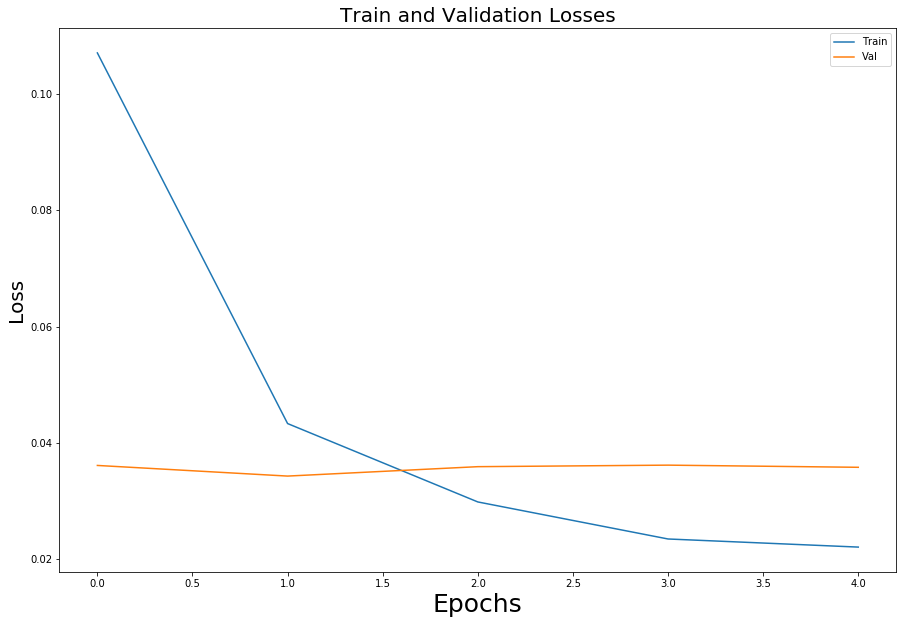

In [20]:
import matplotlib.pyplot as plt 

fig,ax = plt.subplots(1,1,figsize=(15,10))

ax.set_title("Train and Validation Losses",size=20)
ax.set_ylabel('Loss', fontsize = 20) 
ax.set_xlabel('Epochs', fontsize = 25) 
ax.plot(train_losses)
ax.plot(val_losses)
ax.legend(('Train','Val'),loc='upper right')